# Описание задачи

Многие знают про маркетплейсы где продаются б/у вещи, на которых есть возможность недорого купить качественную и полезную вещь. Но всегда волнует вопрос - кто и как устанавливает цену, и какие его характеристики больше всего влияют на итоговую стоимость продажи?! Вопрос становиться особо актуальным, если речь идет про дорогие товары, например про автомобили!

В данном проекте мы будем работать с данными о продажах автомобилей на вторичном рынке c платформы Kaggle (https://www.kaggle.com/competitions/used-cars-price-prediction-19ds/overview). Целью нашего проекта будет разработанная модель предсказания стоимости автомобиля на вторичном рынке.

# Основные этапы исследования

- загрузка и ознакомление с данными,
- предварительная обработка,
- полноценный разведочный анализ,
- разработка новых синтетических признаков,
- проверка на мультиколлинеарность,
- отбор финального набора обучающих признаков,
- выбор и обучение моделей,
- итоговая оценка качества предсказания лучшей модели,
- анализ важности ее признаков.

# Метрика качества

Работа вашей модели будет оцениваться по метрике MAPE (Mean Absolute Percentage Error)
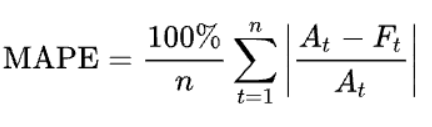

# Данные

- **train.csv** - информация о характеристиках автомобилей (~440000), которые будут использоваться в качестве обучающих данных.
- **test.csv** - информация о характеристиках автомобилей (~110000), которые будут использоваться в качестве тестовых данных. Ваша задача - предсказать значение 'sellingprice' для каждого автомобиля из этого датасета.
- **sample_submission.csv** - пример файла предсказаний в правильном формате.
- **vin** - идентификатор автомобиля в тестовом наборе.
- **sellingprice** - Целевой признак. Для каждого автомобиля предскажите числовое значение стоимости продажи.

# Описание полей данных

- **Date**: Год выпуска автомобиля.
- **Make**: Марка автомобиля.
- **Model**: издание автомобиля определенной марки.
- **Trim**: Уровни отделки салона автомобиля — это просто разные версии модели.
- **Body**: Тип кузова транспортного средства относится к форме и модели конкретной марки автомобиля.
- **Transmission**: механизм, который передает мощность от двигателя к колесам.
- **VIN**: идентификационный номер транспортного средства.
- **State**: состояние, в котором автомобиль выставлен на аукцион.
- **Condition**: Состояние автомобилей на момент аукциона.
- **Odometer**: расстояние, пройденное автомобилем с момента выпуска.
- **Color**: Цвет кузова автомобиля.
- **Interior**: Цвет салона автомобиля.
- **Seller**: Продавец автомобиля, автосалоны.
- **mmr**: Рекорд рынка Manhiem, рыночная оценочная цена автомобилей.
- **sellingprice**: цена, по которой автомобиль был продан на аукционе.
- **saledate**: Дата продажи автомобиля.

# План работы

- 1 Импорт библиотек
- 2 Первый взгляд на данные
- 3 Обработка данных и приведение их к нужному типу
  - 3.1 Приведение всех записей к нижнему регистру и устранение невидимых дубликатов
  - 3.2 Добавление столбцов по saledate
  - 3.3 Добавление столбцов по vin-номеру
- 4 Обработка пропусков
  - 4.1 Обработка категориальных пропусков
  - 4.2 Числовые пропуски
- 5 Анализ на мультиколлинеарность
- 6 Построение модели
  - 6.1 Кодирование признаков
  - 6.2 Модель линейной регрессии
  - 6.3 Дерево решений
  - 6.4 Лес решений
  - 6.5 Catboost
- 7 Подведение итогов


## Анализ данных

### Импорт библиотек

In [1]:
#анализ данных
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import missingno as msno

#заполнение пропусков
from sklearn.impute import SimpleImputer, KNNImputer

#разделение и энкодинг данных
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, OrdinalEncoder

#ML-модели
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import Pool, CatBoostRegressor

#метрикик
from sklearn.metrics import make_scorer, mean_absolute_percentage_error as MAPE

import warnings
import bisect

### Первый взгляд на данные

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
display(train.head(10))

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate
0,2011,Ford,Edge,SEL,suv,automatic,2fmdk3jc4bba41556,md,4.2,111041.0,black,black,santander consumer,12500,Tue Jun 02 2015 02:30:00 GMT-0700 (PDT)
1,2014,Ford,Fusion,SE,Sedan,automatic,3fa6p0h75er208976,mo,3.5,31034.0,black,black,ars/avis budget group,14500,Wed Feb 25 2015 02:00:00 GMT-0800 (PST)
2,2012,Nissan,Sentra,2.0 SL,sedan,automatic,3n1ab6ap4cl698412,nj,2.2,35619.0,black,black,nissan-infiniti lt,9100,Wed Jun 10 2015 02:30:00 GMT-0700 (PDT)
3,2003,HUMMER,H2,Base,suv,automatic,5grgn23u93h101360,tx,2.8,131301.0,gold,beige,wichita falls ford lin inc,13300,Wed Jun 17 2015 03:00:00 GMT-0700 (PDT)
4,2007,Ford,Fusion,SEL,Sedan,automatic,3fahp08z17r268380,md,2.0,127709.0,black,black,purple heart,1300,Tue Feb 03 2015 04:00:00 GMT-0800 (PST)
5,2013,Lincoln,MKZ,Base,Sedan,automatic,3ln6l2j91dr817800,mi,2.5,14894.0,black,black,"ford motor credit company,llc",22600,Thu May 21 2015 02:00:00 GMT-0700 (PDT)
6,2010,pontiac,g6,4c,NaN,automatic,1g2za5eb4a4157380,nc,3.4,114587.0,silver,black,north state acceptance,5900,Mon Jan 12 2015 09:30:00 GMT-0800 (PST)
7,2013,Ford,Escape,SE,SUV,automatic,1fmcu0gx3duc59421,fl,4.8,26273.0,blue,gray,fields bmw,15200,Tue Feb 03 2015 01:00:00 GMT-0800 (PST)
8,2000,Hyundai,Elantra,GLS,Sedan,automatic,kmhjf35f2yu955691,oh,1.9,182624.0,black,tan,dt inventory,700,Thu Jan 22 2015 01:00:00 GMT-0800 (PST)
9,2005,Ford,Freestyle,Limited,wagon,automatic,1fmdk06135ga45438,oh,1.0,149364.0,black,tan,wells fargo dealer services,325,Tue Jun 16 2015 05:00:00 GMT-0700 (PDT)


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440236 entries, 0 to 440235
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          440236 non-null  int64  
 1   make          432193 non-null  object 
 2   model         432113 non-null  object 
 3   trim          431899 non-null  object 
 4   body          429843 non-null  object 
 5   transmission  388775 non-null  object 
 6   vin           440236 non-null  object 
 7   state         440236 non-null  object 
 8   condition     430831 non-null  float64
 9   odometer      440167 non-null  float64
 10  color         439650 non-null  object 
 11  interior      439650 non-null  object 
 12  seller        440236 non-null  object 
 13  sellingprice  440236 non-null  int64  
 14  saledate      440236 non-null  object 
dtypes: float64(2), int64(2), object(11)
memory usage: 50.4+ MB


In [5]:
train.describe()

,year,condition,odometer,sellingprice
count,440236.000000,430831.000000,440167.000000,440236.000000
mean,2010.040101,3.425077,68344.421604,13592.209588
std,3.977945,0.949973,53542.203908,9751.479098
min,1982.000000,1.000000,1.000000,1.000000
25%,2007.000000,2.700000,28258.000000,6900.000000
50%,2012.000000,3.600000,52098.000000,12100.000000
75%,2013.000000,4.200000,99272.000000,18200.000000
max,2015.000000,5.000000,999999.000000,230000.000000


- В данных есть пропуски, которые нужно будет заменить на какие-либо значения либо убрать строки с пропусками. Пропущенные значения содержаться в столбцах `make`, `model`, `trim`, `body`, `transmission`, `condition`, `odometer`, `color`, `interior`.
- Колонка с датой `saledate` имеет неправильный тип данных, нужно будет привести ее к верному типу *datetime64[ns]*

### Обработка данных и приведение их к нужному типу

#### Приведение всех записей к нижнему регистру и устранение неявных дубликатов

В задаче машинного обучения нам необходимо предоставить как можно более качественные данные, поэтому устранение дубликатов и приведение к нижнему регистру (что, по факту, тоже является устранением дублей) - важная часть подготовки данных.

In [6]:
categorical_columns = train.drop(columns=['saledate', 'vin']).select_dtypes(include=['object']).columns.tolist()

#приведем все строковые значения к нижнему регистру    
for column in categorical_columns:
    train[column] = train[column].str.lower()
    test[column] = test[column].str.lower()

for column in categorical_columns:
    if column != 'model' and column != 'trim' and column != 'seller':
        print(f'Список уникальных значений в столбце `{column}` в train: {sorted([str(x) for x in train[column].unique()])}')
        print()

Список уникальных значений в столбце `make` в train: ['acura', 'airstream', 'aston martin', 'audi', 'bentley', 'bmw', 'buick', 'cadillac', 'chevrolet', 'chrysler', 'daewoo', 'dodge', 'dodge tk', 'dot', 'ferrari', 'fiat', 'fisker', 'ford', 'ford truck', 'geo', 'gmc', 'gmc truck', 'honda', 'hummer', 'hyundai', 'infiniti', 'isuzu', 'jaguar', 'jeep', 'kia', 'lamborghini', 'land rover', 'landrover', 'lexus', 'lincoln', 'maserati', 'mazda', 'mazda tk', 'mercedes', 'mercedes-b', 'mercedes-benz', 'mercury', 'mini', 'mitsubishi', 'nan', 'nissan', 'oldsmobile', 'plymouth', 'pontiac', 'porsche', 'ram', 'rolls-royce', 'saab', 'saturn', 'scion', 'smart', 'subaru', 'suzuki', 'tesla', 'toyota', 'volkswagen', 'volvo', 'vw']

Список уникальных значений в столбце `body` в train: ['access cab', 'beetle convertible', 'cab plus', 'cab plus 4', 'club cab', 'convertible', 'coupe', 'crew cab', 'crewmax cab', 'cts coupe', 'cts wagon', 'cts-v coupe', 'cts-v wagon', 'double cab', 'e-series van', 'elantra coupe',

- В данных были обнаружены неявные дубликаты в разделе с маркой автомобиля. В таких значениях называлась марка автомобиля и какой-то индекс для этой марки, либо же использовались разные варианты записи названия автомобиля, например `vw` и `volkswagen`.
- Также в столбцах с цветом `color` и интерьером `interior` были замечаны прочерки, которые свидетельствуют о незаполненнных значениях. В дальнейшем разберемся с этими пропусками.

In [7]:
replace_dict = {
    'dodge tk': 'dodge', 
    'ford truck': 'ford', 
    'gmc truck': 'gmc', 
    'land rover': 'landrover', 
    'mazda tk': 'mazda', 
    'mercedes-b': 'mercedes', 
    'mercedes-benz': 'mercedes', 
    'vw': 'volkswagen'
}

train['make'] = train['make'].replace(replace_dict)
test['make'] = test['make'].replace(replace_dict)

train["color"].replace('—', np.nan, inplace=True)
train["interior"].replace('—', np.nan, inplace=True)
test["color"].replace('—', np.nan, inplace=True)
test["interior"].replace('—', np.nan, inplace=True)

In [8]:
#проверим на наличие явных дубликатов
train.duplicated().sum()

0

In [9]:
#проверим размерность наших датасетов после преобразований
print(train.shape, test.shape)

(440236, 15) (110058, 14)


В задаче борьбы с дубликатами мы не взяли на себя ответственность редактировать и просматривать фичи с моделью (model), уровнем отделки (trim) и продавцом авто (seller), так как подобную информацию лучше брать у целевых специалистов ввиду частичной неполноты информации в открытом доступе.

**Промежуточные итоги**

Все строковые данные приведены к нижнему регистру, исправлены неявные дубликаты в записях, неявные пропуски обозначены явно для дальнейшей борьбы с ними, после преобразований проверена размерность данных с целью убедиться, что данные не потерялись.

#### Добавление столбцов по `saledate`

In [10]:
for df in [train, test]:   
    df['saledate'] = df['saledate'].str.slice(0, -15) # удалить последние 15 символов
    df['saledate'] = pd.to_datetime(df['saledate'], format='%a %b %d %Y %H:%M:%S')
    df['year_sale'] = df['saledate'].dt.year #год продажи
    df['month'] = df['saledate'].dt.month #месяц
    df['day'] = df['saledate'].dt.day #номер дня в месяце
    df['day_of_week'] = df['saledate'].dt.dayofweek #день недели
    df['time'] = df['saledate'].dt.time #время продажи 
    df['age'] = df['year_sale'] - df['year'] #возраст авто

Привел `saledate` к правильному типу и добавил несколько синтетических признаков на основе этой колонки.

In [11]:
train.year_sale

0         2015
1         2015
2         2015
3         2015
4         2015
          ... 
440231    2015
440232    2015
440233    2015
440234    2015
440235    2015
Name: year_sale, Length: 440236, dtype: int64

#### Добавление столбцов по vin-номеру

In [12]:
train.vin

0         2fmdk3jc4bba41556
1         3fa6p0h75er208976
2         3n1ab6ap4cl698412
3         5grgn23u93h101360
4         3fahp08z17r268380
                ...        
440231    knagm4ad4d5057805
440232    wmwzc5c55ewp36517
440233    wbaea53588cv90110
440234    3c6ur5dl2eg243568
440235    jn8as5mt9dw038107
Name: vin, Length: 440236, dtype: object

Я просмотрел значения каждого символа и цифры для VIN-номера. Вот такие у них значения: 1 символ - страна производства; 2-3 - компания производитель; 4-8 - цифры характеризующие модель, тип кузова, двигателя и т.д (у каждой фирмы они означают разное); 9 - контрольная цифра; 10 - год производства; 11 - код завода изготовителя; 12-17 - уникальный серийный номер автомобиля.

In [13]:
train['vin_country'] = train['vin'].str[0]
test['vin_country'] = test['vin'].str[0]

train['vin_make'] = train['vin'].str[1:3]
test['vin_make'] = test['vin'].str[1:3]

train['vin_year'] = train['vin'].str[9]
test['vin_year'] = test['vin'].str[9]

train['vin_manufacturer'] = train['vin'].str[10]
test['vin_manufacturer'] = test['vin'].str[10]

train['vin_4'] = train['vin'].str[3]
test['vin_4'] = test['vin'].str[3]

train['vin_5'] = train['vin'].str[4]
test['vin_5'] = test['vin'].str[4]

train['vin_6'] = train['vin'].str[5]
test['vin_6'] = test['vin'].str[5]

train['vin_7'] = train['vin'].str[6]
test['vin_7'] = test['vin'].str[6]

train['vin_8'] = train['vin'].str[7]
test['vin_8'] = test['vin'].str[7]

train['vin_control'] = train['vin'].str[8]
test['vin_control'] = test['vin'].str[8]

### Обработка пропусков

<AxesSubplot:>

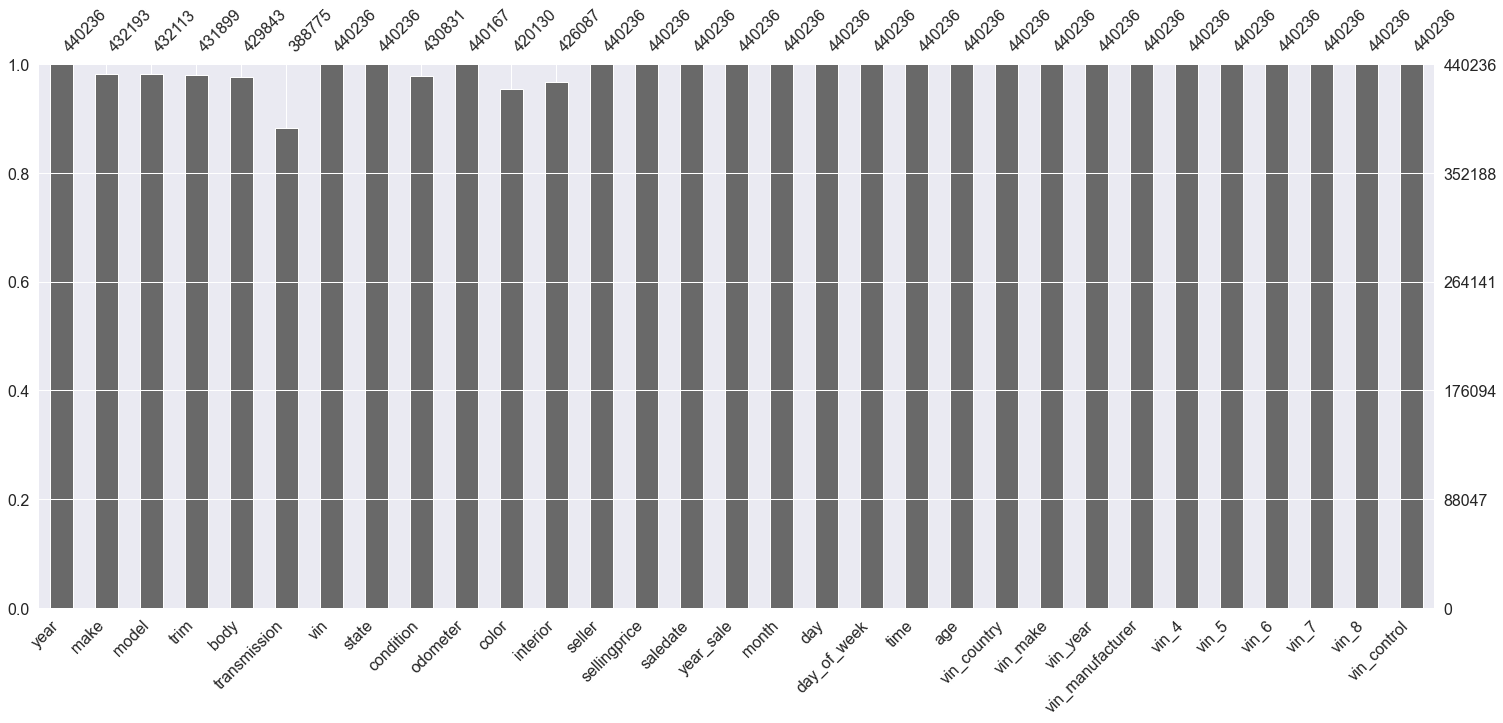

In [14]:
sns.set()
msno.bar(train)

Число пропусков менее 15%, однако еще непонятна природа пропусков.

<AxesSubplot:>

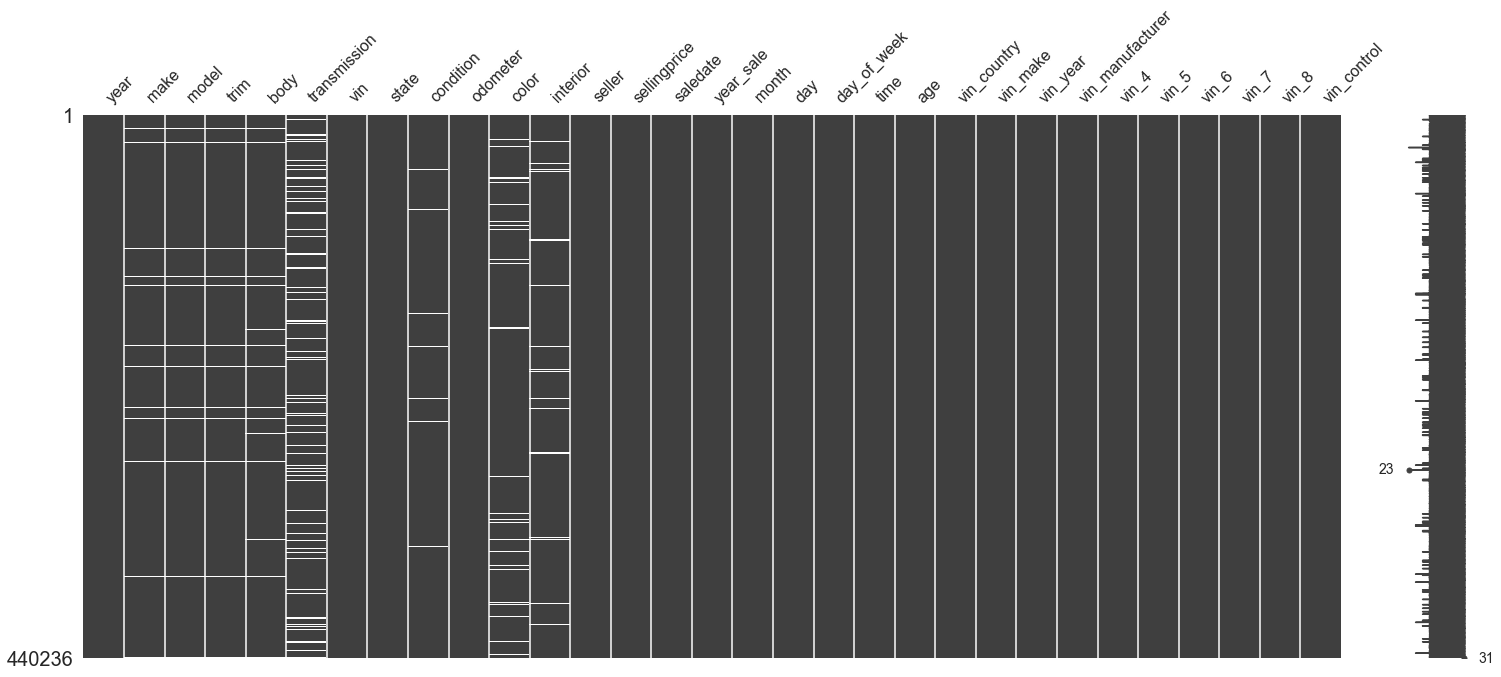

In [15]:
msno.matrix(train)

Как мы видим, пропуски в `color` и `interior` согласуются друг с другом. А также, если есть пропуск в `make`, то будут пропуски в `model`, `trim` и `body`. Для определения зависимости между пропущенными значениями из разных столбцов применим `матрицу корреляции пропущенных значений`.

In [16]:
train[['make', 'model', 'trim', 'body', 'transmission', 'condition', 'odometer', 'color', 'interior']].isnull().corr()

,make,model,trim,body,transmission,condition,odometer,color,interior
make,1.000000,0.994971,0.981875,0.877313,0.023535,-0.012414,0.001002,-0.016600,0.005818
model,0.994971,1.000000,0.976931,0.872853,0.023140,-0.012553,0.000980,-0.015603,0.006597
trim,0.981875,0.976931,1.000000,0.893508,0.022742,-0.006351,0.003585,-0.017063,0.007753
body,0.877313,0.872853,0.893508,1.000000,0.023568,0.026693,0.006419,-0.019970,0.018575
transmission,0.023535,0.023140,0.022742,0.023568,1.000000,0.020664,0.010129,-0.013961,0.041571
condition,-0.012414,-0.012553,-0.006351,0.026693,0.020664,1.000000,0.059642,-0.022841,0.354749
odometer,0.001002,0.000980,0.003585,0.006419,0.010129,0.059642,1.000000,0.003345,0.029612
color,-0.016600,-0.015603,-0.017063,-0.019970,-0.013961,-0.022841,0.003345,1.000000,-0.003714
interior,0.005818,0.006597,0.007753,0.018575,0.041571,0.354749,0.029612,-0.003714,1.000000


Как видно из матрицы корреляции пропущенных значений `make`, `model`, `trim`, `body` очень сильно коррелируют друг с другом. Следовательно, мы можем заполнить пропуски в `make` на основе `vin`-номера и после с помощью группировки заполнять значения в коррелирующих столбцах. То же самое касается и `color`, `interior`.

In [17]:
display(train.isna().sum())
display(test.isna().sum())

year                    0
make                 8043
model                8123
trim                 8337
body                10393
transmission        51461
vin                     0
state                   0
condition            9405
odometer               69
color               20106
interior            14149
seller                  0
sellingprice            0
saledate                0
year_sale               0
month                   0
day                     0
day_of_week             0
time                    0
age                     0
vin_country             0
vin_make                0
vin_year                0
vin_manufacturer        0
vin_4                   0
vin_5                   0
vin_6                   0
vin_7                   0
vin_8                   0
vin_control             0
dtype: int64

year                    0
make                 2061
model                2079
trim                 2114
body                 2594
transmission        13011
vin                     0
state                   0
condition            2379
odometer               19
color                5106
interior             3538
seller                  0
saledate                0
year_sale               0
month                   0
day                     0
day_of_week             0
time                    0
age                     0
vin_country             0
vin_make                0
vin_year                0
vin_manufacturer        0
vin_4                   0
vin_5                   0
vin_6                   0
vin_7                   0
vin_8                   0
vin_control             0
dtype: int64

#### Обработка категориальных пропусков

Заполним пропуски в колонке `make` на основе самых популярных значений в сгруппированных по `vin_make` данных.

In [18]:
# Подсчитываем наиболее часто встречающиеся значения "make" для каждого значения "vin_make" в тестовом датафрейме
mode_dict = train.groupby('vin_make')['make'].agg(lambda x: x.mode()[0] if not x.mode().empty else np.nan).to_dict()

# Функция для заполнения пропусков
def fill_na_with_mode(df, column_to_fill, group_column, mode_dict):
    for group in df[group_column].drop_duplicates().values:
        mask = (df[group_column] == group) & (df[column_to_fill].isna())
        df.loc[mask, column_to_fill] = mode_dict.get(group, np.nan)

# Применяем функцию для обоих датафреймов
fill_na_with_mode(train, 'make', 'vin_make', mode_dict)
fill_na_with_mode(test, 'make', 'vin_make', mode_dict)

In [19]:
mask = train[['model', 'trim', 'body']].isna().all(axis=1)
train.loc[mask, ['model', 'trim', 'body']] = 'Unknown'

mask = test[['model', 'trim', 'body']].isna().all(axis=1)
test.loc[mask, ['model', 'trim', 'body']] = 'Unknown'

In [20]:
cols_to_impute = ['make', 'model', 'trim', 'color', 'interior']

simple_imputer = SimpleImputer(strategy='most_frequent')

train[cols_to_impute] = simple_imputer.fit_transform(train[cols_to_impute])
test[cols_to_impute] = simple_imputer.transform(test[cols_to_impute])

Заполним пропуски в `body` и `transmission` с помощью группировки по марке и модели автомобиля.

In [21]:
def fill_na_with_mode(train, test, column, group_columns=['make', 'model']):
    mode_dict = train.groupby(group_columns)[column].agg(lambda x: x.mode()[0] if not x.mode().empty else np.nan).to_dict()

    for df in [train, test]:
        for group in df[group_columns].drop_duplicates().values:
            mask = (df[group_columns[0]] == group[0]) & (df[group_columns[1]] == group[1]) & (df[column].isna())
            df.loc[mask, column] = mode_dict.get(tuple(group), np.nan)

# Применим функцию
fill_na_with_mode(train, test, 'body')
fill_na_with_mode(train, test, 'transmission')

simple_imputer.fit(train[['body','transmission']])

# Используем обученный imputer для заполнения оставшихся пропусков в обоих датафреймах
for df in [train, test]:
    df[['body','transmission']] = simple_imputer.transform(df[['body','transmission']])
    

#### Числовые пропуски

In [22]:
num_to_input = ['condition', 'odometer']

knn = KNNImputer(n_neighbors=3)

train[num_to_input] = knn.fit_transform(train[num_to_input])
test[num_to_input] = knn.transform(test[num_to_input])

In [23]:
display('Число пропусков в каждом столбце (Train): ')
display(train.isna().sum())
print()
display('Число пропусков в каждом столбце (Train): ')
display(test.isna().sum())

'Число пропусков в каждом столбце (Train): '

year                0
make                0
model               0
trim                0
body                0
transmission        0
vin                 0
state               0
condition           0
odometer            0
color               0
interior            0
seller              0
sellingprice        0
saledate            0
year_sale           0
month               0
day                 0
day_of_week         0
time                0
age                 0
vin_country         0
vin_make            0
vin_year            0
vin_manufacturer    0
vin_4               0
vin_5               0
vin_6               0
vin_7               0
vin_8               0
vin_control         0
dtype: int64

'Число пропусков в каждом столбце (Train): '

year                0
make                0
model               0
trim                0
body                0
transmission        0
vin                 0
state               0
condition           0
odometer            0
color               0
interior            0
seller              0
saledate            0
year_sale           0
month               0
day                 0
day_of_week         0
time                0
age                 0
vin_country         0
vin_make            0
vin_year            0
vin_manufacturer    0
vin_4               0
vin_5               0
vin_6               0
vin_7               0
vin_8               0
vin_control         0
dtype: int64

#### Итоги по предобработке данных

В итоге, мы смогли избавиться от всех категориальных и числовых пропусков в тренировочных и тестовых данных с помощью метода группировки, заполнения модой и метода ближайших соседей. Сначала мы обучали наши алгоритмы на тренировочных данных, а потом применяли их к тренировочным и тестовым данным. Это мы сделали для того, чтобы избежать утечки данных из тестового датасета в тренировочный, тем самым защитили нашу модель от переобучения.

### Анализ на мультиколлениарность

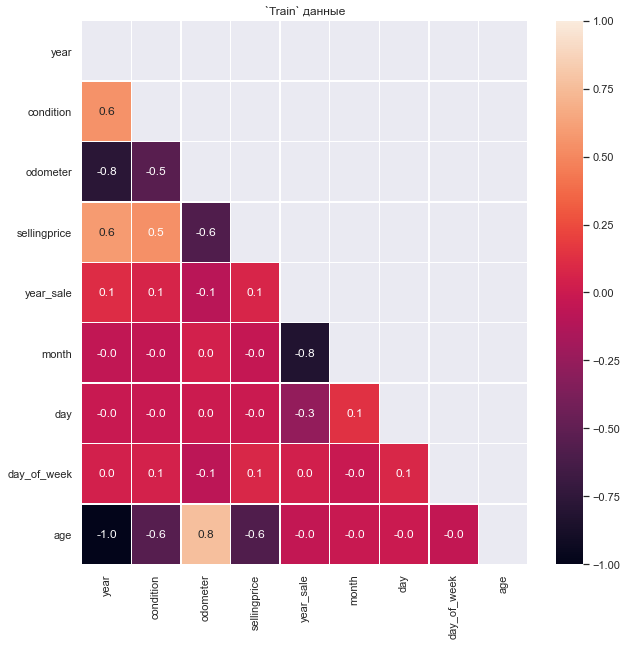

In [24]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title('`Train` данные')
upp_mat = np.triu(train.corr())
sns.heatmap(train.corr(), vmin = -1, vmax = +1, annot = True, mask = upp_mat, ax=ax, linewidth=.5, fmt=".1f")
plt.show()

In [25]:
test_catboost = test.copy()

В данных была замечена мультиколлениарность, однако в в этом проекте мы будем работать в основном с деревянными моделями и бустингами, следовательно, для них мультиколлениарность в данных не страшна.

### Построение модели 

In [26]:
array_of_drop_columns = [
    'sellingprice', 'saledate', 'vin'
    ]

X = train.drop(columns=array_of_drop_columns)
y = train.sellingprice

X_train, X_val, y_train, y_val = train_test_split(
    X, y, random_state=12345, test_size=0.20
)

#### Кодирование признаков

In [27]:
warnings.filterwarnings("ignore")

number_columns = X.select_dtypes(include=['number']).columns.tolist()
object_columns = X.select_dtypes(include=['object']).columns.tolist()

#кодировка числовых признаков
standart_scaler = StandardScaler()
X_train[number_columns] = standart_scaler.fit_transform(X_train[number_columns])
X_val[number_columns] = standart_scaler.transform(X_val[number_columns])
test[number_columns] = standart_scaler.transform(test[number_columns])

#кодировка категориальных признаков
ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X_train[object_columns] = ordinal_encoder.fit_transform(X_train[object_columns])
X_val[object_columns] = ordinal_encoder.transform(X_val[object_columns])
test[object_columns] = ordinal_encoder.transform(test[object_columns])

#### Модель линейной регрессии

In [28]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

l_predict_train = linear_model.predict(X_val)
l_score = MAPE(y_val, l_predict_train) 
print(f'MAPE линейной регрессии для тренировочного сэмпла: {l_score:.3f}')

MAPE линейной регрессии для тренировочного сэмпла: 0.682


In [29]:
#предсказываем
answers = pd.DataFrame()
answers['sellingprice'] = linear_model.predict(test.drop(columns=['saledate', 'vin']))

#### Дерево решений

In [30]:
tree_model = None
tree_MAPE = 100000000000000000

for depth in range(10, 100, 10):
    model = DecisionTreeRegressor(max_depth=depth, random_state=12345)
    model.fit(X_train, y_train)
        
    predictions = model.predict(X_val)
    score = MAPE(y_val, predictions)
        
    if tree_MAPE > score:
        tree_model = model
        tree_MAPE = score
        
print(f'MAPE для дерева решений: {tree_MAPE:.3f}')
print(tree_model)
depth = tree_model.tree_.max_depth

MAPE для дерева решений: 0.210
DecisionTreeRegressor(max_depth=20, random_state=12345)


In [31]:
tree_predict = tree_model.predict(test.drop(columns=['saledate', 'vin']))
answers['sellingprice'] = tree_predict

#### Лес решений

In [32]:
%%time

forest_model = None
forest_MAPE = 100000000000000000

'''for depth in range(10, 50, 5):'''
for n_est in range(10, 50, 10):
    model = RandomForestRegressor(max_depth=depth, n_estimators=n_est, random_state=12345)
    model.fit(X_train, y_train)
    
    predictions = model.predict(X_val)
    score = MAPE(y_val, predictions)
    
    if forest_MAPE > score:
        forest_model = model
        forest_MAPE = score
print(f'MAPE для леса решений: {forest_MAPE:.3f}')
print(forest_model)

MAPE для леса решений: 0.174
RandomForestRegressor(max_depth=20, n_estimators=40, random_state=12345)
Wall time: 6min 43s


In [33]:
forest_predict = forest_model.predict(test.drop(columns=['saledate', 'vin']))
answers['sellingprice'] = forest_predict

#### Catboost

In [34]:
array_of_drop_columns = [
    'sellingprice', 'saledate', 'vin', 'time'
    ]

X = train.drop(columns=array_of_drop_columns)
y = train.sellingprice
category_columns = X.select_dtypes(include=['object']).columns.tolist()

X_train, X_validation, y_train, y_validation = train_test_split(
    X, y, random_state=12345, test_size=0.2
)

train_pool = Pool(data=X_train, label=y_train, cat_features = category_columns)
validation_pool = Pool(data=X_validation, label=y_validation, cat_features = category_columns)

In [35]:
%%time
model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.3,
    eval_metric='MAPE',
    use_best_model=True, 
    random_seed=12345
)
model.fit(
    train_pool, 
    eval_set=validation_pool, 
    verbose=False,
    plot=True
)

print('Model is fitted: {}'.format(model.is_fitted()))
print('Model params:\n{}'.format(model.get_params()))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Model is fitted: True
Model params:
{'iterations': 1000, 'learning_rate': 0.3, 'loss_function': 'RMSE', 'random_seed': 12345, 'use_best_model': True, 'eval_metric': 'MAPE'}
Wall time: 13min 2s


In [36]:
print('Tree count: ' + str(model.tree_count_))

Tree count: 1000


In [37]:
print(model.get_best_score())

{'learn': {'MAPE': 0.2062588724435361, 'RMSE': 1655.6596907402259}, 'validation': {'MAPE': 0.1536605554648422, 'RMSE': 1697.6737004503623}}


In [38]:
X_test = test_catboost.drop(columns=['saledate', 'vin', 'time'])
test_pool = Pool(data=X_test, cat_features=category_columns)
catboost_predict = model.predict(test_pool)
answers['sellingprice'] = catboost_predict

## Подведение итогов

Наиболее выдающиеся результаты показала модель, работающая на Catboost. На валидации ее результат составил 0.17, что превосходит модель линейной регрессии, дерева решений и леса решений.

Посмотрим на фичи, которые модель сочла важными:

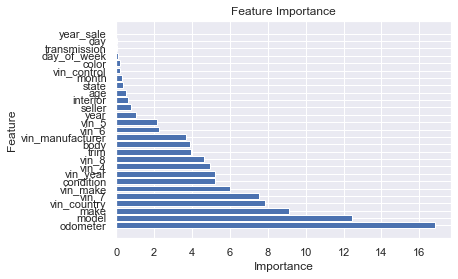

In [39]:
# Получение важности признаков
feature_importance = model.get_feature_importance(prettified=True)

# Создание графика
plt.barh(feature_importance['Feature Id'], feature_importance['Importances'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

- Наиболее весомый вклад внёс пробег, далее модель, марка, страна производства, год выпуска.
- Практически не внесли вклад: год продажи, день выпуска авто, день недели выпуска авто.

### Общий вывод и рекомендации:

**Рекомендации**:
1) Внести с помощью специалиста в данной отрасли в базу данных реально существующие категории, которые можно выбирать при заполнении анкеты на продажу авто в избежание появления дубликатов в данных и, как следствие, ухудшения предсказательной способности модели;
2) Осуществлять обязательную автоматическую проверку введенных данных путем пробития по базам;
3) Сбор обязательный сбор персональных данных продавцов во избежание мошенничества, так как в данных были замечены аномально низкие цены, которые могут вводить в заблуждение юзеров приложения;
4) Для улучшения качества модели можно добавить в анкету такие фичи как примерное количество ремонтов, есть ли неисправности, какие неисправности, последняя дата ТО, был ли какой-то самостоятельный тюнинг авто и какой. Все эти характеристики помогут с большей точностью определять реальную стоимость автомобиля.
5) Проконсультироваться со специалистом для составления большего числа фич, которые помогут понять нашей модели цену авто.

**Вывод**:

Наша модель показала неплохие результаты в 15% ошибки при определении стоимости подержанного авто, при этом определив, что на цену в большей степени влияют пробег, модель, марка, страна производства и год выпуска авто. Отсюда можно сделать вывод, что при дальнейшей работе нашей системы необходим тщательный контроль за этими показателями при составлении анкеты. 

Также можно создать не просто рекомендуюмую цену для выставляемой машины, а ввести диапазон, только в пределах которого продавец может указывать свою цену, но для этого необходимо добавить еще дополнительный категории (число ремонтов, неисправности и т.д. Если же впоследствии от покупателя поступит жалоба, что он сильно переплатил за свой автомобиль, так как он не соответствует заявленным характеристикам, то с нашей стороны необходимо будет заблокировать продавца за недобросовестность. Таким образом, мы сможем минимизировать риски мошенничества на нашей площадке и увеличить уровень качества предоставляемых нами услуг.